# Airfare Price Prediction Project - Data Science

It is important for a traveller to know the fare value of a trip, and as prices of flight ticket change very often it becomes hard for a user to check different websites, and to find different deals. A flight fare prediction model will help inform the travellers when the optimal time to buy their flight tickets, and it will help us understand trends in the airline industry.

The route from New York's JFK airport to London's Heathrow airport(LHR) is one of the busiest air routes in the world. I decided to try and help out the passengers who take this route, by trying to figure out what causes the prices to go up or down, and to create a model that'll be able to predict the price given the appropriate information of a certain flight.

## Data Collection - First Attempt
At first, I had in mind to try and create a model that'll tell the traveller when the prices will be lowest for the route based on previous infromation. Though after searching and scanning the internet I came up with no such data, as the airlines do not publicize this information willingly, and any other companies that offer the service, do not do it free of charge. The only other dataset that seemed to give airfares and information about past flights was from the US Bureau of Transportation Statistics, but it had information on domestic flights only, so it too did not offer anything about the JFK-LHR route.
After understanding that I'll have to get the information by myself, I started recording flight information and their prices using Amadeus's API, (https://developers.amadeus.com/). I wrote a script to get the information and I ran it once a day for a week.

### Data Analizing

The features that I collected for each flight are as followes:
* Airline - the airline carrier of the flight               
* IDs - the IDs of the flight legs
* Date_of_Journey - the date of departure
* Route  - the airport codes for the route
* Dep_Time - the departure time from JFK
* Arrival_Time - the arrival time at LHR
* Duration - the total duration of the flights, including layovers
* Total_Stops - total stops in the journey
* One_Way - is it a round trip or one way ticket
* Last_Ticketing_Date - the last available date for buying the tickets
* Cabins - the ticket's cabin, such as economy and business (or cabins if there's more than one leg)
* Classes - the airline fare class code, for each leg
* Checked_Bags_Included - the number of checked bags allowed 
* Price - the price of the ticket (target feature)
* Date_Taken - the date the information was recorded

In [1]:
import sys; print(sys.version)
import pandas as pd; print (pd.__version__ )
import seaborn as sns; print (sns.__version__)
import matplotlib.pyplot as plt; 
import numpy as np

3.7.6 (default, Jan  8 2020, 20:23:39) [MSC v.1916 64 bit (AMD64)]
1.0.1
0.10.0


In [2]:
# we'll load all the data into dataframe and merge them one with the other to get one large data frame. 
df_flights = pd.read_csv('Airfare1.csv')
filename = 'Airfare'
ending = '.csv'
for i in np.linspace(2,7,6):
    df_flights = df_flights.append(pd.read_csv(filename+str(int(i))+ending))

df_flights.head()

,Airline,IDs,Date_of_Journey,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,One_Way,Last_Ticketing_Date,Cabins,Classes,Checked_Bags_Included,Price,Date_Taken
0,AEROFLOT,"181,182",2020-09-24,JFK→SVO→LHR,2020-09-24T14:15:00,2020-09-25T09:50:00,PT14H35M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
1,AEROFLOT,"189,190",2020-09-24,JFK→SVO→LHR,2020-09-24T00:55:00,2020-09-25T09:30:00,PT27H35M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
2,AEROFLOT,"264,265",2020-09-24,JFK→SVO→LHR,2020-09-24T00:55:00,2020-09-25T09:50:00,PT27H55M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
3,AEROFLOT,"171,172",2020-09-24,JFK→SVO→LHR,2020-09-24T00:55:00,2020-09-24T21:25:00,PT15H30M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24
4,AEROFLOT,"199,200",2020-09-24,JFK→SVO→LHR,2020-09-24T19:20:00,2020-09-25T16:00:00,PT15H40M,1,False,2020-09-24,"ECONOMY,ECONOMY","R,R",1,340.87,2020-09-24


Lets see how many stops these flights have:

Text(0, 0.5, 'Count of flights')

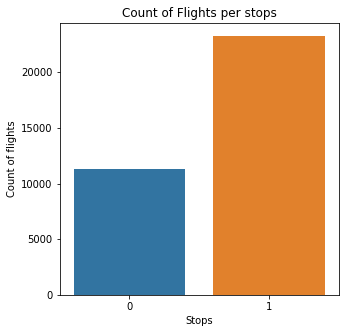

In [3]:
plt.figure(figsize = (5 , 5))
plt.title('Count of Flights per stops')
sns.countplot(x = 'Total_Stops', data = df_flights)
plt.xlabel('Stops')
plt.ylabel('Count of flights')

Let's also see how many of the flights aren't round trips, rather only one way tickets 

In [4]:
print('number of one way tickets:',len(df_flights.where(df_flights['One_Way']==True).dropna()))

number of one way tickets: 0


So the majority of the flights have one stop, but there are also a lot of non-stop flights.
Also every single one of these flights is part of a round trip

One of the most important features of a flight is its duration and it's given to us in ISO 8601 format(https://en.wikipedia.org/wiki/ISO_8601) and it'll be more useful to work with a single number, so we'll convert the hours to minutes and change the column to be in minutes only.

In [5]:
def convert_dur_to_mins(dur):
    '''
    Calculates the number of minutes of a flight duration (in hours and minutes).

            Parameters:
                    dur (string):  A duration of hours and minutes in the ISO 8601 format [PT--H--M,
                                   where the numbers following P represents the number of 
                                   years/months/weeks/days - irrelevent for us, and the numbers following T
                                   represents the number of hours/minutes/seconds]
                    
            Returns:
                    tot (int): the total number of minutes that represent the duration
    '''
    dur = dur[2:] # get rid of 'PT'
    ind_h, ind_m = dur.find('H'), dur.find('M')
    hours = dur[:ind_h]
    if hours != '' :
        hours = int(hours)
    else:
        hours = 0 
        
    mins = dur[ind_h+1:ind_m]
    if mins != '':
        mins = int(mins)
    else:
        mins = 0 
    tot = 60*hours + mins
    return tot

df_flights['Duration'] = pd.Series([convert_dur_to_mins(dur) for dur in df_flights['Duration']])


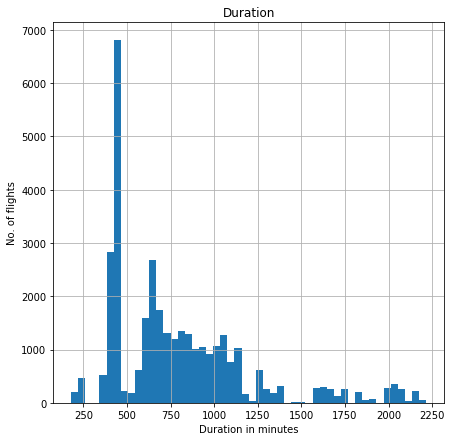

In [6]:
%matplotlib inline 
df_flights.hist(bins=50,column='Duration', figsize=(7,7))
plt.xlabel('Duration in minutes')
plt.ylabel('No. of flights')
plt.show()

From the displayed histogram, we can notice a strange occurence. On the left side, there are a more than a few flights that are less than 250 minutes long. According to the data, these flights would cross the atlantic ocean in less than 5 hours. That is quite strange as the normal non-stop flight from JFK to LHR is approximatly 7 hours = 420 minutes. Beyond that, in general the shortest 1-stop flight is about 530 minutes, so all the 1-stop flights that are shorter than that are also unexpexcted. 

In [7]:
non_stop_flights = df_flights.where(df_flights['Total_Stops'] == 0).dropna()
one_stop_flights = df_flights.where(df_flights['Total_Stops'] == 1).dropna()

#I'll lower the duration bar by 10min because the 410/530 min durations are only approximate.
strange_flights = non_stop_flights.where(non_stop_flights['Duration'] < 410).dropna()
strange_flights = strange_flights.append(one_stop_flights.where(one_stop_flights['Duration'] < 520).dropna())

print('count strange flights:', len(strange_flights))
print('count all flights:', len(df_flights))
print('percentage of strange flights:', round(len(strange_flights) / len(df_flights)*100, 2), '%')

count strange flights: 6308
count all flights: 34542
percentage of strange flights: 18.26 %


This is really quite scary... 
If more than 18% of the flights have bad information about the duration, I'm afraid that the data provided by Amadeus is inaccurate about other features as well, including the prices.

I came to the conclusion that this is not a good approach for the problem for the following reasons: 

* A lot of the data provided by Amadeus is bad. I even tried to find some of the flights on booking sites and found the departure times were also wrong. This made me think that other features might be inaccurate which could change the entire model.

* All the flights seem to be part of a round trip and the price shown is for the whole trip, but none of the inbound flight information is provided, and that could be just as critical for the price prediction as is the information of the outbound flight.


## Data Collection - Second Attempt
I understood that Amadeus's API was not the way to go, so I went to Skyscanner, and it took me a while to get an API key, but in the end I got my hands on one. So using Skyscanner's API(https://skyscanner.github.io/slate/), I wrote a script to collect flight information for tickets from JFK to LHR, for 1 adult, economy class, with a round trip returning after 7 days. I then wrote a script to take the important information that might have some effect on the price, such as airline, duration, departure and arrival time, and put it all in a csv file. I left out some information that has nothing to do with the price, such as the logo's of the different airlines and what the symbol of the dollar is.

I ran the script for the the months of October-December 2020 (93 days in total, as i included  January 1st as well) collecting 106,667 different fares and their appropriate trips,
and we'll see what this data gives us.

### Data Analizing and Preperation

The features that I collected from Skyscanner for each flight are as followes:
* Out_Airline - airline carrier of the outbound flight
* Out_Departure - departure date and time of the outbound flight 
* Out_Arrival - arrival date and time of the outbound flight  
* Out_Duration - outbound flight duration (in minutes) 
* Out_Route - the route of the outbound flight
* In_Airline - airline carrier of the inbound flight
* In_Departure -  departure date and time of the inbound flight
* In_Arrival - arrival date and time of the inbound flight 
* In_Duration -inbound flight duration (in minutes)
* In_Route - the route of the inbound flight
* Out_ID - the id Skyscanner gave to the outbound flight 
* In_ID - the id Skyscanner gave to the inbound flight
* Buying_Url - link for booking the ticket
* Price - the total ticket fare in dollars

In [8]:
df_flights = pd.read_csv('AirFare_Skyscanner.csv')
df_flights.head()

,Out_Airline,Out_Departure,Out_Arrival,Out_Duration,Out_Route,In_Airline,In_Departure,In_Arrival,In_Duration,In_Route,Out_ID,In_ID,Buying_Url,Price
0,British Airways,2020-10-01T21:30:00,2020-10-02T09:35:00,425,JFK→LHR,Virgin Atlantic,2020-10-08T20:15:00,2020-10-08T23:10:00,475,LHR→JFK,12712-2010012130--32222-0-13554-2010020935,13554-2010082015--32132-0-12712-2010082310,https://partners.api.skyscanner.net/apiservice...,1443.20
1,Air France,2020-10-01T19:30:00,2020-10-02T10:40:00,610,JFK→CDG→LHR,Delta,2020-10-08T10:20:00,2020-10-08T13:30:00,490,LHR→JFK,12712-2010011930--32677-1-13554-2010021040,13554-2010081020--32132-0-12712-2010081330,https://partners.api.skyscanner.net/apiservice...,1248.80
2,British Airways,2020-10-01T18:10:00,2020-10-02T06:10:00,420,JFK→LHR,British Airways,2020-10-08T09:30:00,2020-10-08T16:00:00,690,LHR→DUB→JFK,12712-2010011810--32480-0-13554-2010020610,13554-2010080930--32480-1-12712-2010081600,https://partners.api.skyscanner.net/apiservice...,1337.17
3,Delta,2020-10-01T08:30:00,2020-10-02T08:25:00,1135,JFK→ATL→LHR,Delta,2020-10-08T10:20:00,2020-10-08T13:30:00,490,LHR→JFK,12712-2010010830--31697-1-13554-2010020825,13554-2010081020--31697-0-12712-2010081330,https://partners.api.skyscanner.net/apiservice...,1234.25
4,British Airways,2020-10-01T21:30:00,2020-10-02T09:35:00,425,JFK→LHR,British Airways,2020-10-08T10:45:00,2020-10-08T13:35:00,470,LHR→JFK,12712-2010012130--32317-0-13554-2010020935,13554-2010081045--32222-0-12712-2010081335,https://partners.api.skyscanner.net/apiservice...,1281.00


#### Check for Missing Values or Duplicates 

In [9]:
duplicate_rows = df_flights[df_flights.duplicated()]
print("Total duplicate rows except first occurrence based on all columns are :", len(duplicate_rows))


Total duplicate rows except first occurrence based on all columns are : 0


In [10]:
df_flights.isnull().sum()

Out_Airline      0
Out_Departure    0
Out_Arrival      0
Out_Duration     0
Out_Route        0
In_Airline       0
In_Departure     0
In_Arrival       0
In_Duration      0
In_Route         0
Out_ID           0
In_ID            0
Buying_Url       0
Price            0
dtype: int64

In [11]:
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106667 entries, 0 to 106666
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Out_Airline    106667 non-null  object 
 1   Out_Departure  106667 non-null  object 
 2   Out_Arrival    106667 non-null  object 
 3   Out_Duration   106667 non-null  int64  
 4   Out_Route      106667 non-null  object 
 5   In_Airline     106667 non-null  object 
 6   In_Departure   106667 non-null  object 
 7   In_Arrival     106667 non-null  object 
 8   In_Duration    106667 non-null  int64  
 9   In_Route       106667 non-null  object 
 10  Out_ID         106667 non-null  object 
 11  In_ID          106667 non-null  object 
 12  Buying_Url     106667 non-null  object 
 13  Price          106667 non-null  float64
dtypes: float64(1), int64(2), object(11)
memory usage: 11.4+ MB


#### Creating the Test Set  

Since we're interested in creating a good model, we'll have to see if it really is good by testing it on different data. Therefore we'll create a test set by setting aside 20% of the data from our dataframe.
It's good to have a stable train/test split even after the dataset gets updated (if I end up updating it in the future), so I'll be using the instance’s identifier to decide whether or not it should go in the test set.
Updates therefore need to be appended to the end(!) of the dataset.

In [12]:
#  we'll compute a hash of each instance’s identifier and put that instance in the test set if the
# hash is lower than or equal to 20% of the maximum hash value
from zlib import crc32
def test_set_check(identifier, test_ratio):
    
    '''
    Calculates the hash value for the given identifier, and returns whether it falls 
    within the test set, according to the given ratio of the test set.

            Parameters:
                    identifier (int):  an object identifier
                    
                    test_ratio (float):  the ratio of the test set to the original set  
                    
            Returns:
                    True if identifier belongs to the test set
    '''
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    '''
    Splits the given data set into two sets with the ratio given.
            Parameters:
                    data (dataframe):  the data set to split
                    
                    test_ratio (float):  the ratio of the test set to the original set  
                    
                    id_column (string): the name if the identifier column in the data set
                    
            Returns:
                    Two dataframes that consist of the original one, while the second set holds up to
                    the given ratio, and the first completes it.
    '''
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

 # add an `index` column
fares_with_id = df_flights.reset_index()
train_set, test_set = split_train_test_by_id(fares_with_id, 0.2, "index")
print('training set size:', len(train_set), '\ntest set size: ',len(test_set))

training set size: 85333 
test set size:  21334


## Feature Extraction 

We'd prefer having features that'll help us predict the price. We'll use the dates to find out on which month and day the flight takes place, and whether it was on a weekend and which day of the week it's on, as these could definitly help us figure out what the price is.

Also we'll categorize the times to be morning, afternoon, evening, or night flight.


In [13]:
def departtime(x):
    tt = (int)(x.split(':')[0])
    if(tt >= 16 and tt < 21):
        x ='Evening'
    elif(tt >= 21 or tt < 5):
        x ='Night'
    elif(tt >= 5 and tt < 11):
        x ='Morning'
    elif(tt >= 11 and tt < 16):
        x ='Afternoon'
    return x

def add_day_time(df):
        out_hours = []
        for dep in df['Out_Departure']:
            out_hours.append(dep[11:13])
        df.insert(6, 'Out_Time',  list(pd.Series(out_hours).apply(departtime)))

        in_hours = []
        for dep in df['In_Departure']:
            in_hours.append(dep[11:13])
        df.insert(12, 'In_Time',  list(pd.Series(in_hours).apply(departtime)))
        return df
    
train_set = add_day_time(train_set)
test_set = add_day_time(test_set)


Text(0.5, 0, 'Inbound Flight Time')

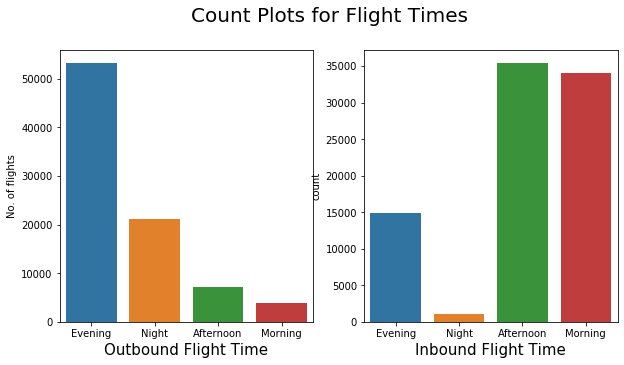

In [14]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2, nrows=1)
plt.suptitle("Count Plots for Flight Times", y = 1, fontsize=20)

sns.countplot(x = 'Out_Time', data = train_set, ax=ax[0],order = train_set['Out_Time'].value_counts().index)
sns.countplot(x = 'In_Time', data = train_set,order = train_set['Out_Time'].value_counts().index)

ax[0].set_ylabel('No. of flights')

ax[0].set_xlabel('Outbound Flight Time',fontsize=15)
ax[1].set_xlabel('Inbound Flight Time',fontsize=15)

In [15]:
def get_as_date_format(date_as_str):
    return pd.to_datetime(date_as_str, format = '%Y/%m/%d')

def add_outbound_features(df):
    out_date = []
    for dep in df['Out_Departure']:
        out_date.append(dep[:10])

    out_date = (pd.Series(out_date)).apply(get_as_date_format)

    df.insert(3,'Out_Is_Weekend',list((out_date.dt.dayofweek// 5 == 1).astype(int)))
    df.insert(3,'Out_Day_Of_Week', list(out_date.dt.day_name()))
    df.insert(3,'Out_Day_Of_Month', list(out_date.dt.day))
    df.insert(3,'Out_Month', list(out_date.dt.month))
    return df

def add_inbound_features(df):
    in_date = []
    for dep in df['In_Departure']:
        in_date.append(dep[:10])

    in_date = (pd.Series(in_date)).apply(get_as_date_format)

    df.insert(13,'In_Is_Weekend',list((in_date.dt.dayofweek// 5 == 1).astype(int)))
    df.insert(13,'In_Day_Of_Week', list(in_date.dt.day_name()))
    df.insert(13,'In_Day_Of_Month', list(in_date.dt.day))
    df.insert(13,'In_Month', list(in_date.dt.month))
    return df


In [16]:
train_set = add_outbound_features(train_set)
test_set = add_outbound_features(test_set)

train_set = add_inbound_features(train_set)
test_set = add_inbound_features(test_set)

With the new features, we'll view some of their different aspects:

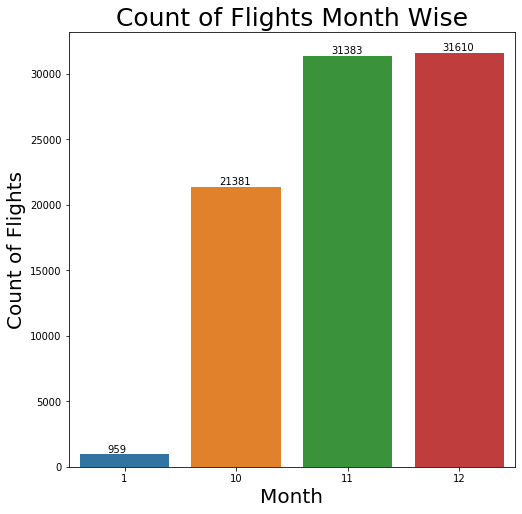

In [17]:
plt.figure(figsize = (8, 8))
plt.title('Count of Flights Month Wise', fontsize = 25)

ax = sns.countplot(x = 'Out_Month', data = train_set)

plt.xlabel('Month', fontsize = 20)
plt.ylabel('Count of Flights', fontsize = 20)

for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va='bottom',
                    color= 'black')

In [18]:
train_set.groupby(['Out_Month']).mean().loc[:, ['Price']].rename(columns={'Price': 'Price Mean'})

,Price Mean
Out_Month,
1,974.456090
10,1411.197396
11,827.108075
12,929.145171


In [19]:
ordered_days = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

train_set.groupby(['Out_Day_Of_Week']).mean().loc[:, ['Price']].rename(columns={'Price': 'Price Mean'}).reindex(ordered_days) 

,Price Mean
Out_Day_Of_Week,
Monday,972.465366
Tuesday,969.025647
Wednesday,930.313891
Thursday,1097.297041
Friday,1042.700043
Saturday,1100.218328
Sunday,980.277329


In [20]:
train_set.groupby(['Out_Is_Weekend']).mean().loc[:, ['Price']].rename(columns={'Price': 'Price Mean'})

,Price Mean
Out_Is_Weekend,
0,1002.658793
1,1039.310672


#### Remove Unnecessary Columns
In response to extracting features, we can remove the columns that have now become futile and no longer grant any benefit.     

In [21]:
def drop_dep_arr_dates(df):
    return df.drop(columns=['In_Departure','Out_Departure','In_Arrival','Out_Arrival'])

train_set =  drop_dep_arr_dates(train_set)
test_set =  drop_dep_arr_dates(test_set)

We'll take another look at the top five rows of our training set: 

In [22]:
train_set.head()

,index,Out_Airline,Out_Month,Out_Day_Of_Month,Out_Day_Of_Week,Out_Is_Weekend,Out_Duration,Out_Route,Out_Time,In_Airline,...,In_Day_Of_Month,In_Day_Of_Week,In_Is_Weekend,In_Duration,In_Route,In_Time,Out_ID,In_ID,Buying_Url,Price
0,0,British Airways,10,1,Thursday,0,425,JFK→LHR,Night,Virgin Atlantic,...,8,Thursday,0,475,LHR→JFK,Evening,12712-2010012130--32222-0-13554-2010020935,13554-2010082015--32132-0-12712-2010082310,https://partners.api.skyscanner.net/apiservice...,1443.20
1,1,Air France,10,1,Thursday,0,610,JFK→CDG→LHR,Evening,Delta,...,8,Thursday,0,490,LHR→JFK,Morning,12712-2010011930--32677-1-13554-2010021040,13554-2010081020--32132-0-12712-2010081330,https://partners.api.skyscanner.net/apiservice...,1248.80
3,3,Delta,10,1,Thursday,0,1135,JFK→ATL→LHR,Morning,Delta,...,8,Thursday,0,490,LHR→JFK,Morning,12712-2010010830--31697-1-13554-2010020825,13554-2010081020--31697-0-12712-2010081330,https://partners.api.skyscanner.net/apiservice...,1234.25
4,4,British Airways,10,1,Thursday,0,425,JFK→LHR,Night,British Airways,...,8,Thursday,0,470,LHR→JFK,Morning,12712-2010012130--32317-0-13554-2010020935,13554-2010081045--32222-0-12712-2010081335,https://partners.api.skyscanner.net/apiservice...,1281.00
6,6,Delta,10,1,Thursday,0,745,JFK→ATL→LHR,Afternoon,Delta,...,8,Thursday,0,490,LHR→JFK,Morning,12712-2010011500--31697-1-13554-2010020825,13554-2010081020--31697-0-12712-2010081330,https://partners.api.skyscanner.net/apiservice...,1234.25


Who's running the most flights between JFK and Heathrow Airport? Why don't we take a quick look.

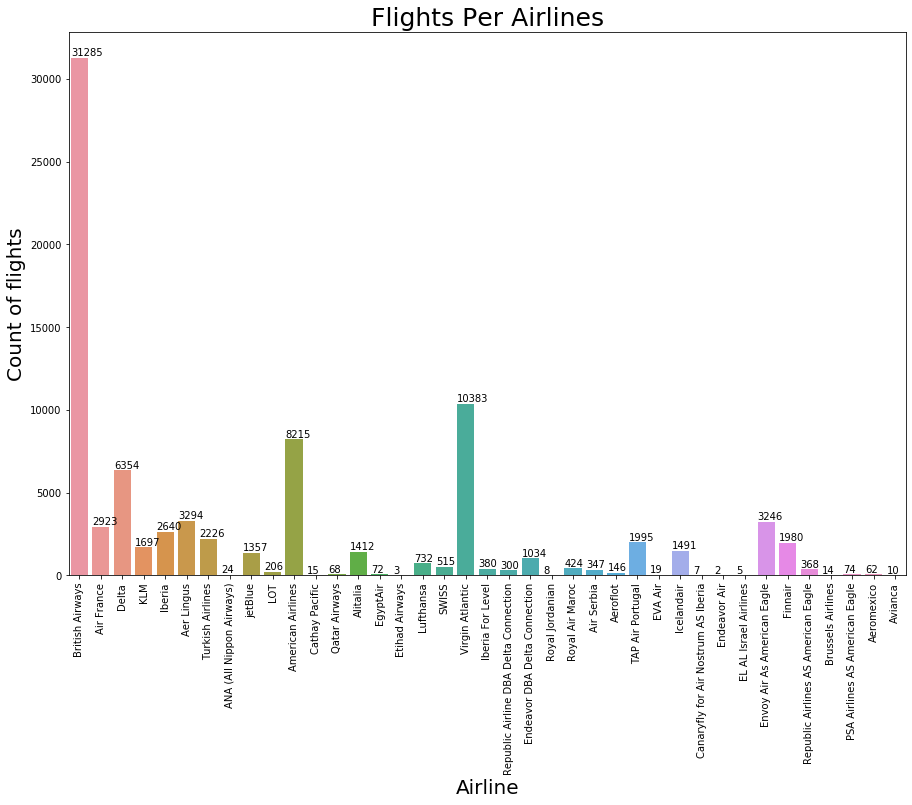

In [23]:
plt.figure(figsize = (15, 10))
plt.title('Flights Per Airlines', fontsize = 25)

ax = sns.countplot(x = 'Out_Airline', data = train_set)

plt.xlabel('Airline', fontsize = 20)
plt.xticks(rotation = 90)
plt.ylabel('Count of flights', fontsize = 20)

for p in ax.patches:
    ax.annotate(int(p.get_height()),
                (p.get_x(), p.get_height()+1),
                va='bottom',
                color= 'black')

And, not very surprisingly, British Airways, Virgin Atlantic (a British airline in itself), and American Airways are in the lead.
Let's see the distribution of the prices over the airlines

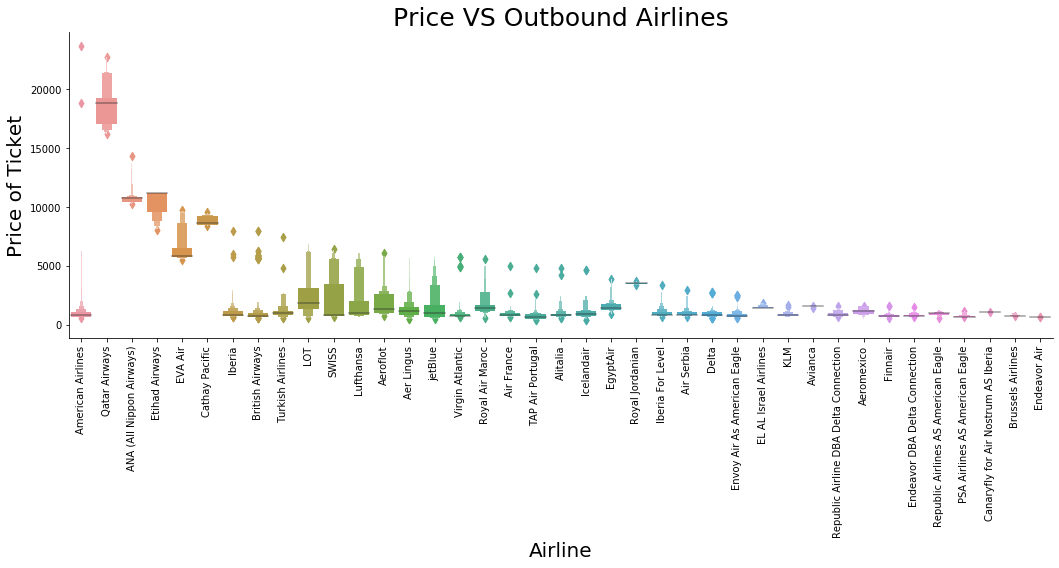

In [24]:
sns.catplot(y = 'Price', x ='Out_Airline',
            data = train_set.sort_values('Price',ascending=False),
            kind='boxen',
            height=5,
            aspect=3)

plt.title('Price VS Outbound Airlines', fontsize = 25)

plt.xlabel('Airline', fontsize = 20)
plt.xticks(rotation = 90)
plt.ylabel('Price of Ticket', fontsize = 20)

plt.show()

It would seem that on the outbound flights the only airlines that are extremely overpriced are Qatar Airways and American Airlines.

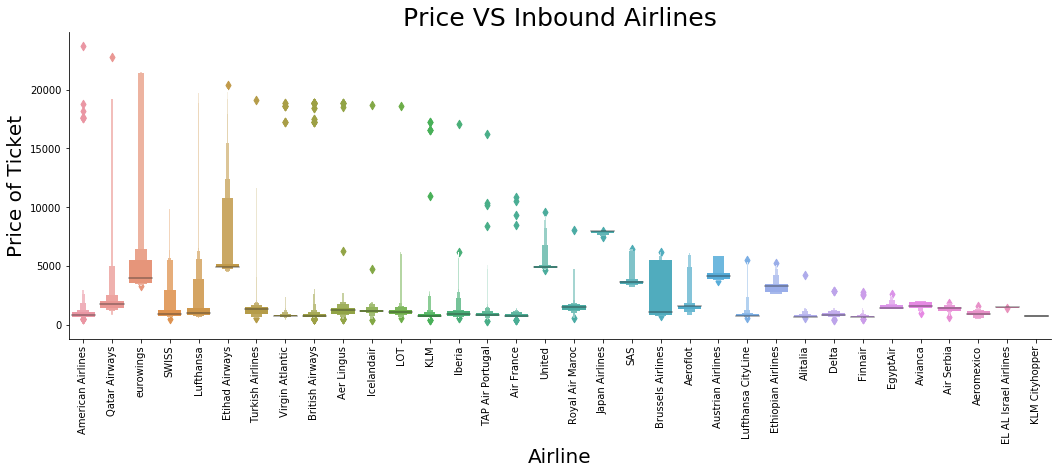

In [25]:
sns.catplot(y = 'Price', x = 'In_Airline',
            data = train_set.sort_values('Price', ascending=False),
            kind='boxen',
            height=5,
            aspect=3)

plt.title('Price VS Inbound Airlines', fontsize = 25)

plt.xlabel('Airline', fontsize = 20)
plt.xticks(rotation = 90)
plt.ylabel('Price of Ticket', fontsize = 20)

plt.show()


It's clear that on the inbound flights there are a lot more airlines that are charging high prices, though it might just be because the round trip includes the first leg which is very expensive, whereas coming back is fairly cheap for all these airlines that appear on the left side of the plot.  

### Encoding Categorical Attributes
It's important to turn all the categorical features into numbers, as preperation for model training. 
We'll start by taking down all the added information that isn't necessary for the models, as well as droping the price from the training set

In [26]:
train_set.columns

Index(['index', 'Out_Airline', 'Out_Month', 'Out_Day_Of_Month',
       'Out_Day_Of_Week', 'Out_Is_Weekend', 'Out_Duration', 'Out_Route',
       'Out_Time', 'In_Airline', 'In_Month', 'In_Day_Of_Month',
       'In_Day_Of_Week', 'In_Is_Weekend', 'In_Duration', 'In_Route', 'In_Time',
       'Out_ID', 'In_ID', 'Buying_Url', 'Price'],
      dtype='object')

In [27]:
def drop_irrelevant_attribs(df):
    return df.drop(columns=['Out_ID','In_ID','Buying_Url'])

#drop price and non-important features in train set
train_set_to_encode = drop_irrelevant_attribs(train_set)
train_set_to_encode = train_set_to_encode.drop(columns = ['Price'])

#drop non-important features in train set
test_set_to_encode = drop_irrelevant_attribs(test_set)

test_set_to_encode.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21334 entries, 2 to 106661
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   index             21334 non-null  int64  
 1   Out_Airline       21334 non-null  object 
 2   Out_Month         21334 non-null  int64  
 3   Out_Day_Of_Month  21334 non-null  int64  
 4   Out_Day_Of_Week   21334 non-null  object 
 5   Out_Is_Weekend    21334 non-null  int64  
 6   Out_Duration      21334 non-null  int64  
 7   Out_Route         21334 non-null  object 
 8   Out_Time          21334 non-null  object 
 9   In_Airline        21334 non-null  object 
 10  In_Month          21334 non-null  int64  
 11  In_Day_Of_Month   21334 non-null  int64  
 12  In_Day_Of_Week    21334 non-null  object 
 13  In_Is_Weekend     21334 non-null  int64  
 14  In_Duration       21334 non-null  int64  
 15  In_Route          21334 non-null  object 
 16  In_Time           21334 non-null  objec

With the help of a label encoder, we'll convert all our categorical features to be numerical

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

numerical_types = ['int64','float64']

train_categorical_data = train_set_to_encode.select_dtypes(exclude=numerical_types)
train_numerical_data = train_set_to_encode.select_dtypes(include=numerical_types)

test_categorical_data = test_set_to_encode.select_dtypes(exclude=numerical_types)
test_numerical_data  = test_set_to_encode.select_dtypes(include=numerical_types)


train_categorical_data.head()

,Out_Airline,Out_Day_Of_Week,Out_Route,Out_Time,In_Airline,In_Day_Of_Week,In_Route,In_Time
0,British Airways,Thursday,JFK→LHR,Night,Virgin Atlantic,Thursday,LHR→JFK,Evening
1,Air France,Thursday,JFK→CDG→LHR,Evening,Delta,Thursday,LHR→JFK,Morning
3,Delta,Thursday,JFK→ATL→LHR,Morning,Delta,Thursday,LHR→JFK,Morning
4,British Airways,Thursday,JFK→LHR,Night,British Airways,Thursday,LHR→JFK,Morning
6,Delta,Thursday,JFK→ATL→LHR,Afternoon,Delta,Thursday,LHR→JFK,Morning


In [29]:
train_categorical_data = train_categorical_data.apply(LabelEncoder().fit_transform)
test_categorical_data = test_categorical_data.apply(LabelEncoder().fit_transform)

In [30]:
train_categorical_data.head()

,Out_Airline,Out_Day_Of_Week,Out_Route,Out_Time,In_Airline,In_Day_Of_Week,In_Route,In_Time
0,9,4,56,3,32,4,50,1
1,4,4,22,1,11,4,50,2
3,13,4,3,2,11,4,50,2
4,9,4,56,3,9,4,50,2
6,13,4,3,0,11,4,50,2


##### Concatenate Catagorical and Numerical Data

In [31]:
X = pd.concat([train_categorical_data, train_numerical_data], axis=1)
y = train_set['Price']

test_set = pd.concat([test_categorical_data, test_numerical_data], axis=1)

Let's have a quick look at the correlation between the features that are left.

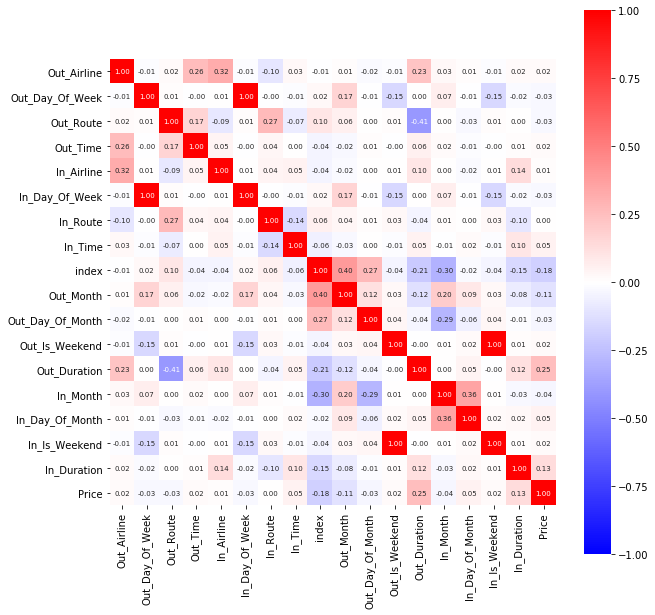

In [32]:
plt.figure(figsize=(10, 10))
hm = sns.heatmap(pd.concat([X,y], axis=1).corr(),
                 vmax=1, vmin=-1, cmap="bwr",
                 square=True, annot=True,
                 fmt='.2f', annot_kws={'size': 7})

From the matrix we see that there is total correlation between :
* The day of the week (sun-sat) of the outbound flight (Out_Day_Of_Week) and the inbound flight (In_Day_Of_Week). This makes sense, as the request we made from Skyscanner was for a trip of exactly 7 days. 

* If the outbound flight is on a weekend (Out_Is_Weekend), then the inbound flight will also be on a weekend (In_Is_Weekend), and vice versa. Once again, that correlation is an immediate outcome of our request for a round trip of 7 days.

Besides those two pairs, all the other features seem to have low correlation with any feature aside themselves.
<br>As a result of our findings, we'll drop the 'In_Day_Of_Week' feature, as well as 'In_Is_Weekend' feature.

In [33]:
def drop_corrolated(df):
    return df.drop(columns=['In_Day_Of_Week','In_Is_Weekend'])

X = drop_corrolated(X)
test_set = drop_corrolated(test_set)

##### Feature scaling

Most of ML algorithms don’t perform well when the input numerical attributes have very different scales. As a result, we need to get all attributes to have the same scale. We'll take the standardization method.

In [34]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# transform data
X_scaled= pd.DataFrame(scaler.fit_transform(X))

X_test_scaled = pd.DataFrame(scaler.fit_transform(test_set.drop('Price', axis = 1)))
y_test = test_set['Price']

# Shortlisting Promising Models



We'll start with the basic *linear regression* model, and see how well it performs.
<br>Then we'll move on to try out some more sophisticated models, in attempt to find a promising model.

In [54]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression(normalize=True)
my_m =lin_reg.fit(X_scaled,y)

Let's evaluate the model by checking out it's score on the training data

In [55]:
lin_reg.score(X_scaled,y)

0.10930685508626724

Terriable. Just terriable. The R^2 here is just a bit over 10% which is very low for a predicting model. Only a tenth of the flight prices are predicted correctly!
<br>Let's approach this problem from a slightly different direction. We'll have a go with the Decision Tree and Random Forest method.

In [56]:
from sklearn.tree import DecisionTreeRegressor

# Build decision tree
dtree_reg = DecisionTreeRegressor(max_depth = 14)
dtree_reg.fit(X_scaled,y)


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=14,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [57]:
dtree_reg.score(X_scaled,y)

0.8000791024442233

Already a great improvement. Perhaps the Random Forest method will give better results, as it works better with non-linear data and is less likely to overfit .  

In [88]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(
                                    n_estimators=100,
                                    max_depth=14,
                                    criterion='mse',
                                    n_jobs=-1)
forest_reg.fit(X_scaled,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=14, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [89]:
forest_reg.score(X_scaled,y)

0.8819567299088823

This seems way better! With 88% of the variance explained, looks like we've made a great improvement.  
Let's check out one more model - the Extreme Gradient Boosting method.

In [90]:
from xgboost import XGBRegressor
xgb_reg = XGBRegressor()
xgb_reg.fit(X_scaled, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [91]:
xgb_reg.score(X_scaled,y)

0.8761675253670511

After looking at the scores of each one of the models when applied to the whole training set, it would be wise to try and get a better evaluation using K-fold cross validation. (We'll leave out the linear regression as it had very poor results.)



In [92]:
from sklearn.model_selection import cross_val_score

DT_accuracies = cross_val_score(estimator = dtree_reg, X = X_scaled, y = y, cv = 10)
RF_accuracies = cross_val_score(estimator = forest_reg, X = X_scaled, y = y, cv = 10)
XGB_accuracies = cross_val_score(estimator = xgb_reg, X = X_scaled, y = y, cv = 10)

In [93]:
print("Mean_DT_Acc: ", DT_accuracies.mean())
print("Mean_RF_Acc: ", RF_accuracies.mean()) 
print("Mean_XGB_Acc: ", XGB_accuracies.mean())

Mean_DT_Acc:  0.4567463105159115
Mean_RF_Acc:  0.6618678973795753
Mean_XGB_Acc:  0.6481671844933328


Looks like the Random Forest model does a better job than the other models, both on the k-folds and on the training set as a whole. Though XGB seems to have some pretty good performances, too.<br>
In that case, I think taking the Random Forest model to the next stage would be wisest.

# Fine-Tuning the System

We'll run a grid search to find the best paramaters for the Random Forest regressor that we've seen above.

The main paramaters are:
* n_estimators: The number of trees in the forest that will be built before taking the averages of predictions. The more trees the  better the performance (at the cost of speed)
* max_depth: The maximum number of levels in each decision tree.  This can be used as one of the stopping criteria for the growth of a tree. 
* min_sample_leaf: The minimum data points allowed in a a leaf node.
* max_features: The maximum number of features Random Forest is allowed to try in individual tree. Increasing this value sometimes improves the performance, since each node has higher number of options to be considered. But it can also worsen the performance, as it decreases the diversity of the individual tree.

In [275]:
from sklearn.model_selection import GridSearchCV

param_grid1 = [{'n_estimators': range(50, 400, 25),
                'max_depth':[2,4,6,8,10,12,14],
                'min_samples_leaf': [1,2,4],
                'max_features':[1,2,3,4,5,6,7,8,9,10,11,12,13,14]}]
forest_reg1 = RandomForestRegressor(n_jobs=-1)

grid_search1 = GridSearchCV(forest_reg1, param_grid1, cv=5, scoring='neg_mean_squared_error')
grid_search1.fit(X_scaled,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=-1,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jobs

In [276]:
print("Best Parameters:", grid_search1.best_params_)

Best Parameters: {'max_depth': 12, 'max_features': 11, 'min_samples_leaf': 4, 'n_estimators': 365}


In [94]:
import pickle
# save the model for when I do a rerun of the notebook. 

filename = 'final_RF_model.sav'
# pickle.dump(grid_search1.best_estimator_, open(filename, 'wb'))

final_model = pickle.load(open(filename, 'rb'))

After running this grid search for almost 2 days, it finally came to an end. Phew!<br>
Perhaps I should have ran it on a few less paramaters, or maybe approched from a different angle, such as using a Bayesian
optimization approach...<br>
Nonetheless, we have finished fine-tuning our model. Let's take a look at the results. 

In [95]:
final_model.score(X_scaled,y)

0.9186904636766052


Wow! 92% to predict the price correctly. Definitly better than our original Random Forest model that got it right only for 87% of the flights. Let's have a go with the K-fold cross validation, just to make sure we're on the right track, with no terrible case of overfitting: 

In [96]:
from sklearn.model_selection import cross_val_score

final_RF_accuracies = cross_val_score(estimator = final_model, X = X_scaled, y = y, cv = 10)
print('Mean_Final_Acc : ', final_RF_accuracies.mean())

Mean_Final_Acc :  0.8678174083224952


Alright, looks pretty good. 
Time for testing it on our real test set!

# Testing and Conclusions

In [97]:
test_score = final_model.score(X_test_scaled,y_test)
print("Test set accuracy:", test_score)

Test set accuracy: 0.8401210573732107


Nice going. We could use some improvement, but let's settle with the 84% score as our final model for the meantime. <br>
Let's try and learn a thing or two about the flights from JFK airport to Heathrow in London, by looking at the weights the model gave to the different features.

In [98]:
feature_importances = final_model.feature_importances_
sorted(zip(feature_importances, X.columns), reverse=True)

[(0.37735011865565643, 'Out_Duration'),
 (0.20483495068671273, 'Out_Route'),
 (0.185361938604791, 'Out_Airline'),
 (0.07536607492274854, 'In_Airline'),
 (0.058093279011852665, 'In_Duration'),
 (0.03325896564441042, 'In_Route'),
 (0.03115224018987707, 'Out_Time'),
 (0.016177092781992926, 'Out_Day_Of_Week'),
 (0.011134877925422145, 'Out_Day_Of_Month'),
 (0.00887912339260591, 'In_Day_Of_Month'),
 (0.008627504218758466, 'Out_Month'),
 (0.006882687608549657, 'In_Time'),
 (0.0020301123411831895, 'In_Month'),
 (0.0013263374500094983, 'Out_Is_Weekend')]


Let's make a list of our findings:
1. So, as expected, the duration of the outbound flight is the most important feature here and it affects the price the most.<br>
2. The next important features are the route of the outbound flight, and the airline carriers flying both there and back.<br> It's interesting to see that the inbound flight affects the ticket price a lot less then the outbound flight. One would think they might have a similar weight, but hey, that's not what it looks like from our model!<br>
3. Another noticable thing is that the weekends just barley affect the price. Guess we shouldn't be worried about flying during the weekends anymore.<br>
4. In contrast, if we look at the other features we added during the exraction phase (the day of the week, the day of the month, and the month itself), we'll see that they weren't entirely useless, and they do have some sort of an impact. 

And there we have it - our initial goals have been completed.


## Improvements for the Future

There's always, but always, room to improve our model. Now that we've seen which features have less of an impact on the price, maybe we can get better results by removing some of them. I'd also like to try and test out some other types of models.  Another idea is to try and clean out some of the outliers and see how it affects our predictions and training time. And of course, to be constantly updating the data and expanding the model more and more. But all these ideas will have to wait for the moment...

# Reflection

I'm really glad I took this data science course. I learned a lot from it and it broadend my horizons greatly. At the beginning, I was a bit skeptical as to how much I'd gain from this project , but in truth, it's given me so much. From the basics of ticket pricing, to experimenting with differents APIs, to training and testing my very own model. I got to delve into the world of regression, understand how the Random Forests learning method works from all sides, and got a taste of some other ML algorithms as well. Though there were many ups and down along the way, I am satisified with the work that's been done and the results that have been achived. <br>
I hope to learn more about the field in the future, and who knows, maybe even work in it some day. 